In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
from scipy.stats import norm
import random
import seaborn as sns

## Inversion

### Example with Exponential distribution

In [2]:
# beta = 1 / lambda
beta = 0.1
size = 10000

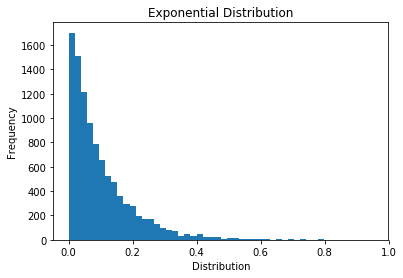

In [3]:
X = np.random.exponential(beta, size=size)

plt.title("Exponential Distribution")
plt.ylabel("Frequency")
plt.xlabel("Distribution")
plt.hist(X, bins=50);

Inversion of the Cumulative Distribution Function :

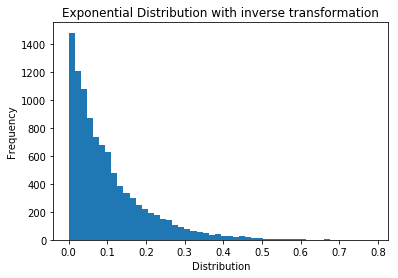

In [4]:
Y = - beta * np.log(np.random.uniform(size=size))

plt.title("Exponential Distribution with inverse transformation")
plt.ylabel("Frequency")
plt.xlabel("Distribution")
plt.hist(Y, bins=50);

## Rejection

### Introduction to Rejection

If you can simple a uniform distribution on [0,1] and you want to sample on a smaller interval, you can "select" the number you generated.

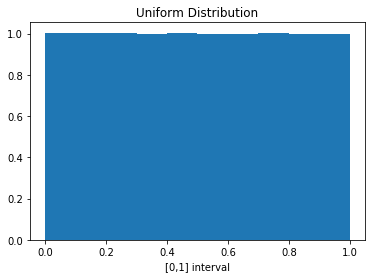

In [19]:
U = np.random.uniform(size=10**6)

plt.title("Uniform Distribution")
plt.xlabel("[0,1] interval")
plt.hist(U,density=True);

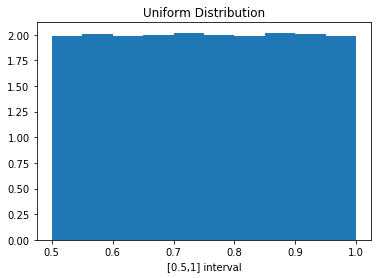

In [23]:
V = U[U>0.5]

plt.title("Uniform Distribution")
plt.xlabel("[0.5,1] interval")
plt.hist(V,density=True);

Suppose we have some observations from the density we want to generate (here, $f$ function) and we know how to sample with a $g$ function.

**Note :** The probability distribution function shows how the sample should look like. It doesn't give a way to generate such a sample.

In [31]:
def f(x):
    """
    Compute normal density
    """
    return 1/np.sqrt(2*np.pi) * np.exp(-1/2*x**2)

def g(x):
    """
    Computer Cauchy distribution density
    """
    return 1/(np.pi*(1+x**2))

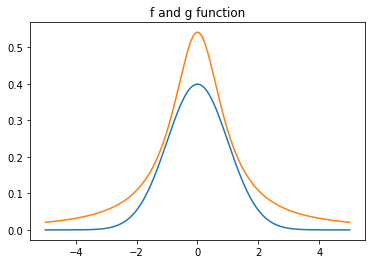

In [41]:
interval = np.linspace(-5,5,1000)

fx = f(interval)
gx = M*g(interval)

plt.title("f and g function")
plt.plot(interval,fx)
plt.plot(interval,gx)

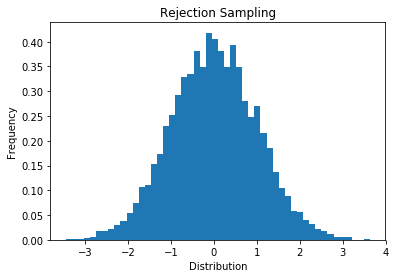

In [34]:
M = 1.7
Y = np.random.standard_cauchy(size=size)
U = np.random.uniform(size=size)

generated_sample = Y[ U<=f(Y)/(M*g(Y)) ]

plt.title("Rejection Sampling")
plt.ylabel("Frequency")
plt.xlabel("Distribution")
plt.hist(generated_sample, density=True, bins=50);

## Chain Rule

## Ziggurat algorithm

We apply the ziggurat algorithm in order to generate from the standard normal distribution. However, this algorithm can also be applied to generate from a monotone decreasing probability distribution or an other symmetric unimodal distribution.

In [2]:
y_max = 1/math.sqrt(2*math.pi)

def normal_density(t):
    """
    This function is the probability density of the normal distribution
    Args:
    - t (float)
    """
    return y_max*math.exp(-(t**2)/2)

def inverse_normal_density(u):
    """
    This function is the inverse probability density of the normal distribution
    Args:
    - u (float) : between 0 and 1/sqrt(2PI)
    """
    return math.sqrt(-2*math.log(math.sqrt(2*math.pi)*u))


We first build the regions along the density curve. As the computing of the strict value of a possible regions division is difficult, we start from a supposed value of x1 and truncate the top region.

In [3]:
def error_for_top_region(x,y):
    """
    This function returns the error in the top region, i.e. the difference of area with the area of other regions
    Args:
    - x (float[]): table of x-coordinates of regions
    - y (float[]): table of y-coordinates of regions
    """
    return abs(area_by_region(x,y)-2*(x[-2]*(y[-1]-y[-2])))

def area_by_region(x,y):
    """
    This function returns the area of the regions defined by x and y supposing they have all same area
    Args:
    - x (float[]): table of x-coordinates of regions
    - y (float[]): table of y-coordinates of regions
    """
    return 2*x[1]*(y[2]-y[1])

def compute_x_y(x1):
    """
    This function returns tables of coordinates of regions of the ziggurat algorithm supposing the second region,
    i.e. the first rectangle over the tails region, is defined along x-axis by [-x1;x1]
    Args:
    - x1 (float):
    """
    x = [math.inf,x1]
    y = [0,normal_density(x1)]
    
    #compute area of regions based on supposed x1 value
    area_by_region = 2*(x[1]*y[1]+norm.cdf(-x[1]))
    #define factice x[0] value preparing Marsaglia method
    x[0] = area_by_region/y[1]
    
    y.append(y[-1]+area_by_region/(2*x[-1]))
    
    #Regions are built one by one from the bottom in such a way that they have the same area,
    #until we reach the bottom of the probability density curve
    while y[-1] < y_max:
        x.append(inverse_normal_density(y[-1]))
        y.append(y[-1]+area_by_region/(2*x[-1]))
    
    #The last region obtained is truncated
    y[-1] = y_max
    x.append(0)
        
    return x, y

Then we can apply the ziggurat algorithm over these regions. It proceeds as follows :
    - Choosing a region
    - If the bottom region (with tails) is chosen, following a special procedure. (Marsaglia method here, but we could have repeat ziggurat_algorithm along the tails)
    - Else, generating an uniform random point in the rectangle. If the point is not under the density curve, repeating the whole process.

In [4]:
def ziggurat_algorithm(x,y):
    
    chosen_region = random.randint(0, len(x)-2)

    if chosen_region == 0:
        x_aleat = x[0]*(2*random.random()-1)
        if (-x[1] <= x_aleat <= x[1]):
            return x_aleat
        else:
            #Marsaglia method
            x_tail = -math.log(random.random())/x[1]
            y_tail = -math.log(random.random())
            if 2*y_tail > x_tail**2:
                return x[1]+x_tail
            else:
                return ziggurat_algorithm(x,y)

    x_aleat = x[chosen_region]*(2*random.random()-1)
    y_aleat = (y[chosen_region+1]-y[chosen_region])*random.random()

    if (-x[chosen_region+1] <= x_aleat <= x[chosen_region+1]) or (y_aleat <= normal_density(x_aleat)):
        return x_aleat
    else:
        return ziggurat_algorithm(x,y)
        
def generate_normal(x,y,nb_generations):
    return [ziggurat_algorithm(x,y) for i in range(nb_generations)]

As a first step, we can draw the built regions over the density curve in order to get a sense of it, for a little number of regions :

In [5]:
x,y = compute_x_y(2.5)
len(x)

12

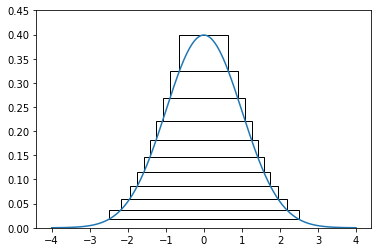

In [6]:
fig,ax = plt.subplots(1)

for i in range(1,len(x)-1):
    ax.add_patch(
        patches.Rectangle(
            xy=(-x[i], y[i]),
            width=2*x[i],
            height=y[i+1]-y[i],
            linewidth=1,
            fill=False
        )
    )

x_values = np.linspace(-4,4,1000)
normal_density_values = [normal_density(i) for i in x_values]

plt.ylim(0,0.45)
plt.plot(x_values, normal_density_values)
plt.show()

Let's do this with more regions for more accuracy. We compute the coordinates of the regions :

In [8]:
x, y = compute_x_y(4)

In [9]:
area_by_region(x,y)

0.0011339842897853225

We can verify the error of the truncated region does not seem too significant :

In [10]:
error_for_top_region(x,y)

0.0002682185689969342

We are finally able to generate many values and plot their pleasant normal distribution :

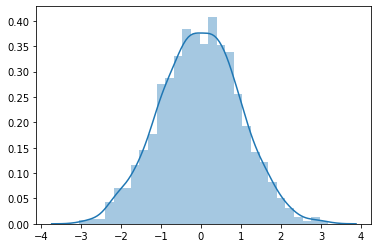

In [13]:
sns.distplot(generate_normal(x,y,2000))

# Specialized generation method

### Box-Muller

In [11]:
U = np.random.uniform(size=10**6)
V = np.random.uniform(size=10**6)

X = np.sqrt(-2*np.log(U))*np.cos(2*np.pi*V)
Y = np.sqrt(-2*np.log(U))*np.sin(2*np.pi*V)

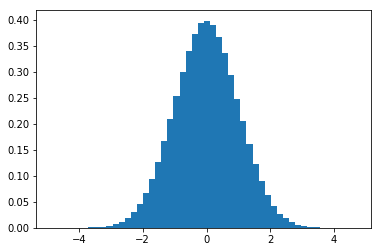

In [13]:
plt.hist(X, density=True, bins=50);

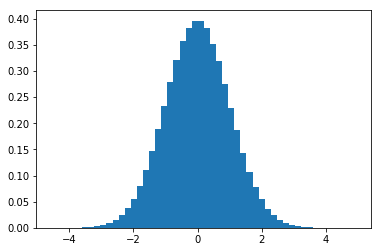

In [14]:
plt.hist(Y, density=True, bins=50);

### Box-Muller with rejection

In [26]:
U = np.random.uniform(-1,1,size=10**6)
V = np.random.uniform(-1,1,size=10**6)

S = U**2 + V**2

#Keep only S <= 1
idx = S<=1
S = S[idx]

K = np.sqrt(-2*np.log(S)/S)

X = U[idx]*K
Y = V[idx]*K

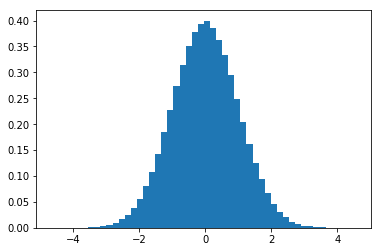

In [28]:
plt.hist(X, density=True, bins=50);

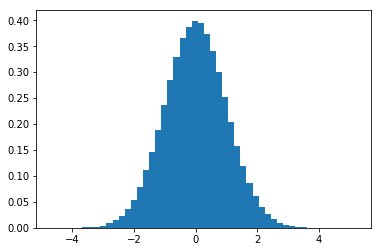

In [29]:
plt.hist(Y, density=True, bins=50);